# Pipeline of Digits

This is a starting notebook for solving the "Pipeline of Digits" assignment.


This notebook was created by [Santiago L. Valdarrama](https://twitter.com/svpino) as part of the [Machine Learning School](https://www.ml.school) program.

Let's make sure we are running the latest version of the SakeMaker's SDK. **Restart the notebook** after you upgrade the library.

In [2]:

!pip install -q --upgrade awscli boto3
# !pip install -q --upgrade PyYAML==6.0
!pip install -q --upgrade sagemaker==2.165.0
!pip install pip
!pip install scikit-learn==1.3.0
!pip install pandas==1.3.3
!pip install joblib
!pip install matplotlib==3.6.0


You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.1 MB 21.5 MB/s            
     |████████████████████████████████| 302 kB 42.8 MB/s            
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.5 MB 9.6 MB/s            
  Attempting uninstall: pandas
    Found existing

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import os
import sys
import pandas as pd

from pathlib import Path
import sagemaker

## Creating the S3 Bucket

Let's create an S3 bucket where you will upload all the information generated by the pipeline. Make sure you set `BUCKET` to the name of the bucket you want to use. This name has to be unique.

If you want to create a bucket in a region other than `us-east-1`, use this command instead:

```
!aws s3api create-bucket --bucket $BUCKET --create-bucket-configuration LocationConstraint=$region
```

The `LocationConstraint` argument should specify the region where you want to create the bucket.

In [6]:
BUCKET = 'vmate-mnist-1'

!aws s3api create-bucket --bucket $BUCKET --create-bucket-configuration LocationConstraint="eu-north-1"


An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


## Loading the dataset

We have two CSV files containing the MNIST dataset. These files come from the [MNIST in CSV](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv) Kaggle dataset.

The `mnist_train.csv` file contains 60,000 training examples and labels. The `mnist_test.csv` contains 10,000 test examples and labels. Each row consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255).

Let's extract the `dataset.tar.gz` file.

In [7]:
MNIST_FOLDER = Path('mnist')
DATASET_FOLDER = Path('dataset')
CODE_FOLDER = Path('code')
CODE_FOLDER.mkdir(parents=True, exist_ok=True)
sys.path.append('./code')

!tar -xvzf dataset.tar.gz --no-same-owner

dataset/
dataset/mnist_test.csv
dataset/mnist_train.csv


Let's load the first 10 rows of the test set.

In [8]:
df = pd.read_csv(DATASET_FOLDER / 'mnist_train.csv', nrows=10)
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## S3 upload / locations

In [9]:
S3_LOCATION = f's3://{BUCKET}/{MNIST_FOLDER}'

TRAIN_SET_S3_URI = sagemaker.s3.S3Uploader.upload(
    local_path=str(DATASET_FOLDER / 'mnist_train.csv'), 
    desired_s3_uri=S3_LOCATION,
)

TEST_SET_S3_URI = sagemaker.s3.S3Uploader.upload(
    local_path=str(DATASET_FOLDER / 'mnist_test.csv'), 
    desired_s3_uri=S3_LOCATION,
)

PROCESSED_SET_S3_BASE_URI = f'{S3_LOCATION}/preprocessed_data',


print(f'Train set S3 location: {TRAIN_SET_S3_URI}')
print(f'Test set S3 location: {TEST_SET_S3_URI}')
print(f'Processed set S3 location: {PROCESSED_SET_S3_BASE_URI}')


Train set S3 location: s3://vmate-mnist-1/mnist/mnist_train.csv
Test set S3 location: s3://vmate-mnist-1/mnist/mnist_test.csv
Processed set S3 location: ('s3://vmate-mnist-1/mnist/preprocessed_data',)


In [10]:
%%writefile {CODE_FOLDER}/preprocessor.py

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from pickle import dump
from typing import Tuple


DEFAULT_BASE_DIR = Path('/opt')/'ml'/'processing'
DATA_DIR='./dataset'

def _preprocess_pipeline(df_data: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:    
    num_classes = 10

    categorical_transformer = Pipeline(
        steps=[
            ('encoder', OneHotEncoder())            
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('labels', categorical_transformer, ['label'])
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline(
        steps=[
            ("preprocess", preprocessor)
        ]
    )
    data: np.ndarray = pipeline.fit_transform(df_data)
    # OneHotEncoded
    y_data: np.ndarray = data[:, :num_classes]
    # Drop OneHotEncoded target variable
    data = np.delete(data,np.arange(num_classes), axis=1)

    X_train, X_test_validation, y_data, y_test_validation = train_test_split(data, y_data, test_size=0.2, random_state=7)
    X_test, X_validation, y_test, y_validation = train_test_split(X_test_validation, y_test_validation, test_size=0.5, random_state=7)

    return X_train, X_test, X_validation, y_data, y_test, y_validation


def _save_pipeline(base_dir: str, pipeline: Pipeline):  
    
    pipeline_path = Path(base_dir)
    pipeline_path.mkdir(parents=True, exist_ok=True)
    dump(pipeline, open(pipeline_path / 'pipeline.pkl', 'wb'))

def preprocess(base_dir, data_dir):
    
    if base_dir is None:
        base_dir = DEFAULT_BASE_DIR
        
    base_dir = Path(base_dir)
    (base_dir / 'train').mkdir(parents=True, exist_ok=True)
    (base_dir / 'validation').mkdir(parents=True, exist_ok=True)
    (base_dir / 'test').mkdir(parents=True, exist_ok=True)
    (base_dir / 'labels').mkdir(parents=True, exist_ok=True)
        
    df_data: pd.DataFrame =  pd.read_csv(Path(data_dir) / 'mnist_train.csv')

    df_test: pd.DataFrame =  pd.read_csv(Path(data_dir) / 'mnist_test.csv')

    df_data: np.ndarray = pd.concat([df_data, df_test], axis=0)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df_data['label'])

    X_train, X_test, X_validation, y_train, y_test, y_validation  = _preprocess_pipeline(df_data)    

    np.savetxt(base_dir / 'train' / 'mnist_train.csv', np.concatenate([X_train, y_train], axis=1), delimiter=',')
    np.savetxt(base_dir / 'test' / 'mnist_test.csv', np.concatenate([X_test, y_test], axis=1), delimiter=',')
    np.savetxt(base_dir / 'validation' / 'mnist_validation.csv', np.concatenate([X_validation, y_validation], axis=1), delimiter=',')
    np.savetxt(base_dir / 'labels' / 'labels.csv', labels, delimiter=',')

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--base_dir', type=str, dest='base_dir', default=DEFAULT_BASE_DIR)
    parser.add_argument('--data_dir', type=str, dest='data_dir', default=DATA_DIR)

    args, _ = parser.parse_known_args()
    
    preprocess(
        base_dir=args.base_dir,
        data_dir=arg.data_dir
    )

Overwriting code/preprocessor.py


In [11]:
%%writefile {CODE_FOLDER}/train.py

from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt 

model_path = Path('model') / '001'
image_size = 28 * 28
def create(no_features):  
    model = Sequential([
        Dense(32, activation='sigmoid'),
        Dense(10, activation='softmax'),
    ])
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None,no_features)) # Comeback to this, find out what 'None' is.  
    return model

def train(X_train, y_train, X_test, y_test):
    model = create(X_train.shape[1])
    model.summary()
    
    history = model.fit(X_train, y_train, batch_size=18, epochs=5, validation_split=.1, verbose=True)
    model.save(model_path)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=True)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(accuracy)

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print(f'Loss: {loss:.3}, Accuracy: {accuracy:.3}')


Overwriting code/train.py


In [12]:
%%writefile {CODE_FOLDER}/evaluation.py

import os
import json
import tarfile
import numpy as np
import pandas as pd

from pathlib import Path
from tensorflow import keras
from sklearn.metrics import accuracy_score


MODEL_PATH = "/opt/ml/processing/model/"
TEST_PATH = "/opt/ml/processing/test/"
OUTPUT_PATH = "/opt/ml/processing/evaluation/"


def evaluate(model_path, test_path, output_path):
    # The first step is to extract the model package so we can load 
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))
        
    model = keras.models.load_model(Path(model_path) / "001")
    
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test.drop(X_test.columns[-1], axis=1, inplace=True)
    
    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "accuracy": {
                "value": accuracy
            },
        },
    }
    
    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))


if __name__ == "__main__":
    evaluate(
        model_path=MODEL_PATH, 
        test_path=TEST_PATH,
        output_path=OUTPUT_PATH
    )

Overwriting code/evaluation.py


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25440     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,770
Trainable params: 25,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2023-08-28 12:14:49.181 tensorflow-2-6-cpu-py-ml-t3-medium-97b05bbe92bff9d43abb12500182:391 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-08-28 12:14:49.561 tenso

INFO:tensorflow:Assets written to: model/001/assets


875/875 [==============================] - 3s 3ms/step - loss: 0.5197 - accuracy: 0.8554


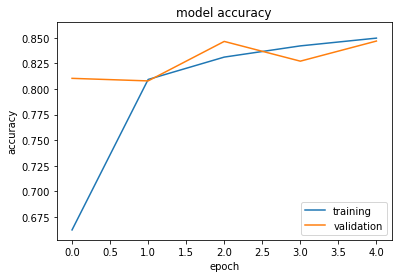

Loss: 0.52, Accuracy: 0.855


In [14]:
import numpy as np
from train import train
from joblib import Memory
from typing import Tuple
from preprocessor import preprocess

# memory = Memory(location='./cache', verbose=0)

# @memory.cache
def load_csv(sample=None) -> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray]:
    num_classes = 10

        
    directory = Path('./preprocessed_dataset/')
    
    df = pd.read_csv(directory / 'train' / 'mnist_train.csv')
    df_X_train = df.sample(frac=0.5, random_state=1)
    df_X_test = df.sample(frac=0.5, random_state=1)
    # X_train = np.genfromtxt(directory / 'train' / 'mnist_train.csv', delimiter=',')
    # X_test = np.genfromtxt(directory / 'test' / 'mnist_test.csv', delimiter=',')
    

    y_train = df_X_train.values[:, -num_classes:]
    y_test = df_X_test.values[:, -num_classes:]
    
    
    return df_X_train.values, y_train, df_X_test.values, y_test

# preprocess(
#     base_dir='./preprocessed_dataset',
#     data_dir='./dataset'
# )

X_train, y_train, X_test, y_test = load_csv(0.1)

train(X_train, y_train, X_test, y_test)

In [15]:
import tempfile  
from preprocessor import preprocess


directory = Path('./preprocessed_dataset')
directory.mkdir(parents=True, exist_ok=True)

preprocess(
    base_dir=directory,
    data_filepath=Path(DATASET_FOLDER),
)
print(f'Folders: {os.listdir(directory)}')

TypeError: preprocess() got an unexpected keyword argument 'data_filepath'

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import CacheConfig
from sagemaker.tuner import HyperParameter 

train_input= ParameterString(
    name='train_data_location',
    default_value=TRAIN_SET_S3_URI
)

test_input= ParameterString(
    name='test_data_location',
    default_value=TEST_SET_S3_URI
)

processed_data_output_location= ParameterString(
    name='processed_data_output_location',
    default_value=PROCESSED_SET_S3_URI
)

In [ ]:

cache_config = CacheConfig(
    enable_caching=True,
    expire_after='15d',
)
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type="ml.m3.medium",
    instance_count=1,
)

preprocessing_step = ProcessingStep(
    name='mnist_preprocessing',
    processor = sklearn_processor,
    inputs=[
        ProcessingInput(source=train_input, destination='/opt/ml/processing/train'),
        ProcessingInput(source=test_input, destination='/opt/ml/processing/test'),
    ],
    outputs = [
        ProcessingOutput(output_name='train', source='/opt/ml/processing/train', destination=processed_data_output_location),
        ProcessingOutput(output_name='validation', source='/opt/ml/processing/validation', destination=processed_data_output_location),
        ProcessingOutput(output_name='test', source='/opt/ml/processing/test', destination=processed_data_output_location),
    ],
    code='code/preprocessor.py',
    cache_config=cache_config,
)

In [ ]:
tensorflow_processor = TensorFlow(
    entry_point=f'{CODE_FOLDER}/train.py'
    framework_version='2.6',
    role=role,
    instance_type='m1.m3.medium',
    instance_count=1,
    base_job_name='mnist_train'
    py_version='py38',
)

step_args = tensorflow.fit(
    estimator=estimator,
    inputs={
        'train': TrainingInput(
            s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                'train'
            ].S3Output.S3Uri,
            content_type='text/csv'
        ),
        'validation': TrainingInput(
            s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                'validation'
            ].S3Output.S3Uri,
            content_type='text/csv'
        ),
        'test': TrainingInput(
            s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                'test'
            ].S3Output.S3Uri,
            content_type='text/csv'
        ),
    }
)

training_step = TrainingStep(
    name='mnist_train',
    step_args=step_args,
    cache_config=cache_config,
)

In [ ]:

pipeline = Pipeline(
    name="mnist_pipeline",
    parameters=[
        train_input_location,
        test_input_location,
        processed_data_output_location,
    ],
    steps=[preprocessing_step, training_step, validation_step, registration_step],
)